In [1]:
# Importing Dependencies
import findspark
findspark.init()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pyspark.sql.functions import col, to_date, unix_timestamp
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report
import numpy as np
from pyspark.sql import SparkSession
import time
import hvplot.pandas
from sklearn import tree
from sklearn.metrics import classification_report
from pyspark.sql.types import DoubleType
from mpl_toolkits.mplot3d.axes3d import Axes3D
from sklearn import linear_model
import matplotlib.pyplot as plt

# Hiding warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# Read in the data into a DataFrame.
from pyspark import SparkFiles
url = "http://abc11274.sg-host.com/wp-content/uploads/2024/07/realtor-data.zip.csv"
spark.sparkContext.addFile(url)

df = spark.read.csv(SparkFiles.get("realtor-data.zip.csv"), sep=",", header=True)

df.show()

+-----------+--------+--------+---+----+--------+---------+-------------+-----------+--------+----------+--------------+
|brokered_by|  status|   price|bed|bath|acre_lot|   street|         city|      state|zip_code|house_size|prev_sold_date|
+-----------+--------+--------+---+----+--------+---------+-------------+-----------+--------+----------+--------------+
|   103378.0|for_sale|105000.0|  3|   2|    0.12|1962661.0|     Adjuntas|Puerto Rico|   00601|     920.0|          NULL|
|    52707.0|for_sale| 80000.0|  4|   2|    0.08|1902874.0|     Adjuntas|Puerto Rico|   00601|    1527.0|          NULL|
|   103379.0|for_sale| 67000.0|  2|   1|    0.15|1404990.0|   Juana Diaz|Puerto Rico|   00795|     748.0|          NULL|
|    31239.0|for_sale|145000.0|  4|   2|     0.1|1947675.0|        Ponce|Puerto Rico|   00731|    1800.0|          NULL|
|    34632.0|for_sale| 65000.0|  6|   2|    0.05| 331151.0|     Mayaguez|Puerto Rico|   00680|      NULL|          NULL|
|   103378.0|for_sale|179000.0| 

## Data Cleaning

In [4]:
# Create a temporary view of the DataFrame.
df.createOrReplaceTempView("real_estate_sales")

In [5]:
# Keeping only sold properties
df = df.filter(df['status'] == 'sold')
# Replacing all None values with 0
df = df.fillna(0)
# Dropping house_size = 0 rows
df = df.filter(df['house_size'] != 0)
# Dropping house_size < 10,000
df = df.filter(df['house_size'] < 10000)
# Dropping price < 10,000,000
df = df.filter(df['price'] < 5000000)

# Dropping acre_lot < 2
df = df.filter(df['acre_lot'] < 2)
# Removing bed/bath outliers
df = df.filter((col('bath') <= 20) & (col('bed') <= 20))
# Converting data types
df = df.withColumn('status', col('status').cast('string'))
df = df.withColumn('brokered_by', col('brokered_by').cast('int'))
df = df.withColumn('price', col('price').cast('double'))
df = df.withColumn('bed', col('bed').cast('int'))
df = df.withColumn('bath', col('bath').cast('int'))
df = df.withColumn('house_size', col('house_size').cast('int'))
df = df.withColumn('acre_lot', col('acre_lot').cast(DoubleType()))
df = df.withColumn('street', col('street').cast('string'))
df = df.withColumn('city', col('city').cast('string'))
df = df.withColumn('state', col('state').cast('string'))
df = df.withColumn('zip_code', col('zip_code').cast('string'))
df = df.withColumn('prev_sold_date', col('prev_sold_date').cast('string'))

In [6]:
# Converting to pandas dataframe
pandas_df = df.toPandas()

In [7]:
# Creating "property_type" column
def classify_house_size(size):
    if size < 1500:
        return 'small'
    elif 1500 <= size < 3000:
        return 'medium'
    else:
        return 'large'

pandas_df['property_type'] = pandas_df['house_size'].apply(classify_house_size)

In [8]:
# Settting brokered_by as index
pandas_df.set_index('brokered_by')
pandas_df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date,property_type
0,72457.0,sold,524900.0,3,2,0.09,1850809.0,Aguada,Puerto Rico,00602,2200,2021-12-13,medium
1,61711.0,sold,90000.0,3,2,0.08,141421.0,Aguadilla,Puerto Rico,00603,1421,2021-10-19,small
2,49592.0,sold,22500.0,2,1,0.32,1889894.0,Anasco,Puerto Rico,00610,850,2021-12-30,small
3,72408.0,sold,168000.0,6,4,0.05,1157317.0,Anasco,Puerto Rico,00610,3422,2021-10-21,large
4,60830.0,sold,380000.0,2,2,0.19,1857001.0,Arecibo,Puerto Rico,00612,1210,2022-03-06,small


In [9]:
# Checking data types
print(pandas_df.dtypes)

brokered_by       float64
status             object
price             float64
bed                 int32
bath                int32
acre_lot          float64
street             object
city               object
state              object
zip_code           object
house_size          int32
prev_sold_date     object
property_type      object
dtype: object


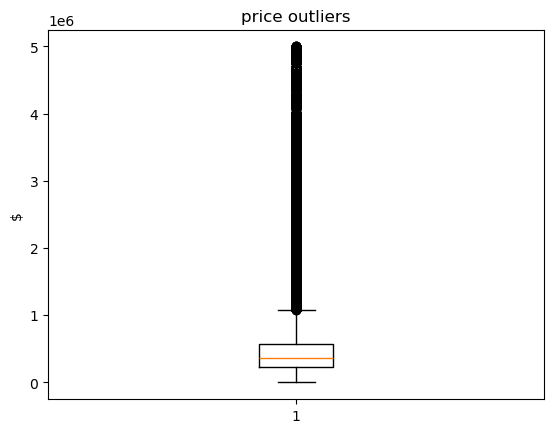

In [10]:
prices = pandas_df['price']
figOut, axOut = plt.subplots()
axOut.set_title('price outliers')
axOut.set_ylabel('$')
axOut.boxplot(prices)
plt.show()

In [11]:
quartiles = prices.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of prices is: {lowerq}")
print(f"The upper quartile of prices is: {upperq}")
print(f"The interquartile range of prices is: {iqr}")
print(f"The the median of prices is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of prices is: 235000.0
The upper quartile of prices is: 575000.0
The interquartile range of prices is: 340000.0
The the median of prices is: 367500.0 
Values below -275000.0 could be outliers.
Values above 1085000.0 could be outliers.


In [12]:
# Dropping columns

dropped_pandas_df = pandas_df.drop(['status', 'acre_lot', 'street', 'city', 'zip_code', 'prev_sold_date','brokered_by'], axis=1)
dropped_pandas_df.head()

,price,bed,bath,state,house_size,property_type
0,524900.0,3,2,Puerto Rico,2200,medium
1,90000.0,3,2,Puerto Rico,1421,small
2,22500.0,2,1,Puerto Rico,850,small
3,168000.0,6,4,Puerto Rico,3422,large
4,380000.0,2,2,Puerto Rico,1210,small


## Machine Learning LINEAR REGRESSION

### Encoding

In [13]:
# Exporting encoded data
encoded_df = pd.get_dummies(dropped_pandas_df)

# Replace NaN values with 0
encoded_df = encoded_df.fillna(0)

encoded_df = encoded_df.astype(int)
encoded_df.to_csv('Resources/encoded_data_full.csv', index=False)

In [14]:
encoded_df.head()

,price,bed,bath,house_size,state_Alabama,state_Arizona,state_Arkansas,state_California,state_Colorado,state_Connecticut,...,state_Vermont,state_Virgin Islands,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming,property_type_large,property_type_medium,property_type_small
0,524900,3,2,2200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,90000,3,2,1421,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,22500,2,1,850,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,168000,6,4,3422,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,380000,2,2,1210,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Linear Regression

In [15]:
X = encoded_df[['bed', 'bath', 'house_size']]
y = encoded_df['price']

model = LinearRegression()

model.fit(X, y)

bedrooms = 3
bathrooms = 3
house_size = 2000

# Combine the input values into a single array
input_data = [[bedrooms, bathrooms, house_size]]

# Make the prediction
predicted_price = model.predict(input_data)[0]

# Display the prediction
print(f"Predicted price for a property with {bedrooms} bedrooms, {bathrooms} bathrooms, and {house_size} square feet: ${predicted_price:.2f}")

Predicted price for a property with 3 bedrooms, 3 bathrooms, and 2000 square feet: $580509.92


#### Training & Evaluation

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a model with scikit-learn
model = LinearRegression()

# Fit the data into the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 243067.64
Mean Squared Error (MSE): 157152263647.11
Root Mean Squared Error (RMSE): 396424.35
R-squared (R²): 0.25


For the inital model, the performance is less than optimal.
- The model's predictions are off by nearly $280,000 on average.
- The typical prediction error is about $600,000

Further optimization of this model is needed.

#### Optimization

In [17]:
# Adding more features to the encoded dataframe, now includes lot size
# Dropping columns
optimized_dropped_pandas_df = pandas_df.drop(['status', 'city', 'street','state','zip_code', 'prev_sold_date'], axis=1)
optimized_dropped_pandas_df.head()

,brokered_by,price,bed,bath,acre_lot,house_size,property_type
0,72457.0,524900.0,3,2,0.09,2200,medium
1,61711.0,90000.0,3,2,0.08,1421,small
2,49592.0,22500.0,2,1,0.32,850,small
3,72408.0,168000.0,6,4,0.05,3422,large
4,60830.0,380000.0,2,2,0.19,1210,small


In [18]:
# Encoding
optimized_encoded_df = pd.get_dummies(optimized_dropped_pandas_df)

# Replace NaN values with 0
optimized_encoded_df = optimized_encoded_df.fillna(0)

optimized_encoded_df.to_csv('Resources/optimized_encoded_df.csv', index=False)

In [19]:
optimized_encoded_df

,brokered_by,price,bed,bath,acre_lot,house_size,property_type_large,property_type_medium,property_type_small
0,72457.0,524900.0,3,2,0.09,2200,False,True,False
1,61711.0,90000.0,3,2,0.08,1421,False,False,True
2,49592.0,22500.0,2,1,0.32,850,False,False,True
3,72408.0,168000.0,6,4,0.05,3422,True,False,False
4,60830.0,380000.0,2,2,0.19,1210,False,False,True
...,...,...,...,...,...,...,...,...,...
565242,23009.0,359900.0,4,2,0.33,3600,True,False,False
565243,18208.0,350000.0,3,2,0.10,1616,False,True,False
565244,76856.0,440000.0,6,3,0.50,3200,True,False,False
565245,53618.0,179900.0,2,1,0.09,933,False,False,True


In [20]:
# Adding acres as 4th input

X = optimized_encoded_df[['bed', 'bath', 'house_size', 'acre_lot']]
y = optimized_encoded_df['price']

model = LinearRegression()

model.fit(X, y)

bedrooms = 3
bathrooms = 3
house_size = 2000
acres = 4.5

# Combine the input values into a single array
input_data = [[bedrooms, bathrooms, house_size, acres]]

# Make the prediction
predicted_price = model.predict(input_data)[0]

# Display the prediction
print(f"Predicted price for a {acres} acre property with {bedrooms} bedrooms, {bathrooms} bathrooms, and {house_size} square feet: ${predicted_price:.2f}")

Predicted price for a 4.5 acre property with 3 bedrooms, 3 bathrooms, and 2000 square feet: $318692.55


In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a model with scikit-learn
model = LinearRegression()

# Fit the data into the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 242807.34
Mean Squared Error (MSE): 156798005865.37
Root Mean Squared Error (RMSE): 395977.28
R-squared (R²): 0.25


Adding acres to the model did make it slightly more accurate, but not substantial.

## 3D Linear Regression

In [22]:
X = encoded_df[['bed','bath']].values.reshape(-1,2)
Y = encoded_df['price']

x_ = X[:,0]
y_ = X[:,1]
z = Y

x_pred = np.linspace(0, 20, 30)   
y_pred = np.linspace(0, 20, 30
                     )  
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

ols = linear_model.LinearRegression()

model = ols.fit(X, Y)
predicted = model.predict(model_viz)

r2 = model.score(X, Y)

Text(0.5, 0.98, '$R^2 = 0.22$')

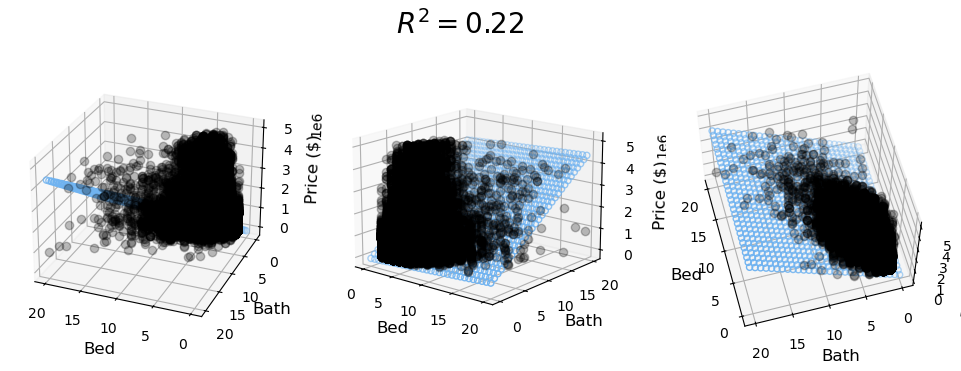

In [23]:
plt.style.use('default')
fig1 = plt.figure(figsize=(12, 4))
ax1 = fig1.add_subplot(131, projection='3d')
ax2 = fig1.add_subplot(132, projection='3d')
ax3 = fig1.add_subplot(133, projection='3d')
axes = [ax1, ax2, ax3]
for ax in axes:
    ax.plot(x_, y_, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.25)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Bed', fontsize=12)
    ax.set_ylabel('Bath', fontsize=12)
    ax.set_zlabel('Price ($)', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')
ax1.view_init(elev=27, azim=112)
ax2.view_init(elev=16, azim=-51)
ax3.view_init(elev=60, azim=165)
fig1.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

## Random Forest Regressor

In [24]:
X = encoded_df.drop(columns='price')
y = encoded_df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

In [25]:
# Make predictions
predictions = rf_model.predict(X_test)

In [26]:
feature_list = list(X.columns)

In [27]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))


Mean Absolute Error (MAE): 175736.6253688776
Mean Squared Error (MSE): 107401192181.87314
R-squared (R²): 0.48649266659831225
Accuracy: 81.06 %.
Mean Absolute Percentage Error (MAPE): 1893.75


In [28]:
# Get numerical feature importances
importances = list(rf_model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:12} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: house_size   Importance: 0.47
Variable: state_California Importance: 0.22
Variable: bath         Importance: 0.17
Variable: bed          Importance: 0.05
Variable: state_Washington Importance: 0.02
Variable: state_Arizona Importance: 0.01
Variable: state_District of Columbia Importance: 0.01
Variable: state_Florida Importance: 0.01
Variable: state_Massachusetts Importance: 0.01
Variable: state_Oregon Importance: 0.01
Variable: state_Alabama Importance: 0.0
Variable: state_Arkansas Importance: 0.0
Variable: state_Colorado Importance: 0.0
Variable: state_Connecticut Importance: 0.0
Variable: state_Delaware Importance: 0.0
Variable: state_Georgia Importance: 0.0
Variable: state_Hawaii Importance: 0.0
Variable: state_Idaho  Importance: 0.0
Variable: state_Illinois Importance: 0.0
Variable: state_Indiana Importance: 0.0
Variable: state_Iowa   Importance: 0.0
Variable: state_Kansas Importance: 0.0
Variable: state_Kentucky Importance: 0.0
Variable: state_Louisiana Importance: 0.0
Va

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Visualizing a Random Forest for the state of California

In [29]:
#Filtering so it only has California States
cali_only = encoded_df.loc[encoded_df['state_California']==1]
cali_only = cali_only[['price','bed','bath','house_size','state_California','property_type_small',
                      'property_type_medium','property_type_large',]]
cali_only

,price,bed,bath,house_size,state_California,property_type_small,property_type_medium,property_type_large
408541,205000,3,2,1883,1,0,1,0
408547,151000,2,1,768,1,1,0,0
408548,109000,5,2,1368,1,1,0,0
408571,175000,3,1,1008,1,1,0,0
408586,134999,2,1,921,1,1,0,0
...,...,...,...,...,...,...,...,...
529457,525000,1,1,607,1,1,0,0
529458,459400,3,1,1160,1,1,0,0
529462,850000,4,3,1956,1,0,1,0
529466,959000,4,3,1824,1,0,1,0


In [30]:
X_cali = np.reshape(cali_only['house_size'],(-1,1))
X = X_cali
y = cali_only['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rf_model_cali = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model_cali.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [31]:
predictions = rf_model_cali.predict(X_test)

In [32]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))


Mean Absolute Error (MAE): 389305.9828040442
Mean Squared Error (MSE): 332022036597.22687
R-squared (R²): 0.2512681132140503
Accuracy: 99.5 %.
Mean Absolute Percentage Error (MAPE): 50.31


In [33]:
#reshaping of numbers into 1D arrays
y_plot = np.reshape(y,(-1,1))
X_test_plot = X_test.flatten()
X_cali_plot = X_cali.flatten()
y_plot_test = y_plot.flatten()

#Turning the data into a DataFrame 
true_data = pd.DataFrame(data={'House_size':X_cali_plot,'actual':y_plot_test})
predictions_data = pd.DataFrame(data = {'House_Size':X_test_plot,'predicted':predictions})


Text(0.5, 1.0, 'Actual vs Predicted (California)')

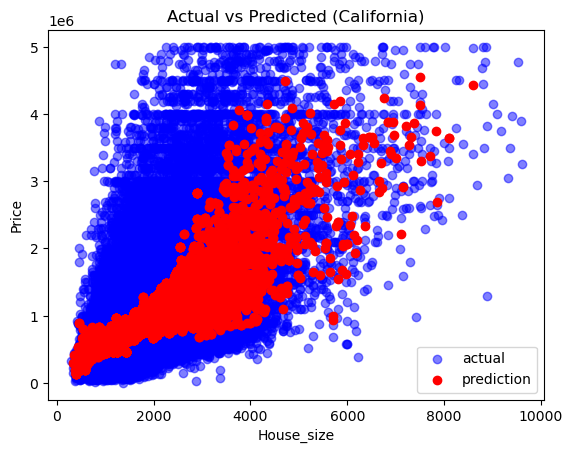

In [34]:
plt.scatter(X_cali_plot,true_data['actual'],color='blue', label='actual',alpha= .5)
plt.scatter(X_test_plot,predictions_data['predicted'],color = 'red',marker = 'o',label='prediction')
plt.legend()
plt.xlabel('House_size')
plt.ylabel('Price')
plt.title('Actual vs Predicted (California)')

### Visualizing a Random Forest for the state of Oregon

In [41]:
#Filtering so it only has Oregon States
oreg_only = encoded_df.loc[encoded_df['state_Oregon']==1]
oreg_only = oreg_only[['price','bed','bath','house_size','state_Oregon','property_type_small',
                      'property_type_medium','property_type_large',]]
oreg_only


,price,bed,bath,house_size,state_Oregon,property_type_small,property_type_medium,property_type_large
391399,95000,1,1,528,1,1,0,0
391488,240000,5,2,2032,1,0,1,0
391548,225000,2,1,1359,1,1,0,0
391605,242500,3,2,1660,1,0,1,0
391675,82000,3,1,1008,1,1,0,0
...,...,...,...,...,...,...,...,...
565210,260000,5,1,2374,1,0,1,0
565211,291500,3,2,1520,1,0,1,0
565212,209500,2,1,1148,1,1,0,0
565221,280000,3,2,1274,1,1,0,0


In [42]:
X_oreg = np.reshape(oreg_only['house_size'],(-1,1))
X = X_oreg
y = oreg_only['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rf_model_oreg = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model_oreg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [43]:
predictions = rf_model_oreg.predict(X_test)

In [44]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))


Mean Absolute Error (MAE): 137901.77167772708
Mean Squared Error (MSE): 51070346116.53171
R-squared (R²): 0.4713190811968756
Accuracy: 99.75 %.
Mean Absolute Percentage Error (MAPE): 24.81


In [45]:
#reshaping of numbers into 1D arrays
y_plot = np.reshape(y,(-1,1))
X_test_plot = X_test.flatten()
X_oreg_plot = X_oreg.flatten()
y_plot_test = y_plot.flatten()

#Turning the data into a DataFrame 
true_data = pd.DataFrame(data={'House_size':X_oreg_plot,'actual':y_plot_test})
predictions_data = pd.DataFrame(data = {'House_Size':X_test_plot,'predicted':predictions})

Text(0.5, 1.0, 'Actual vs Predicted (Oregon)')

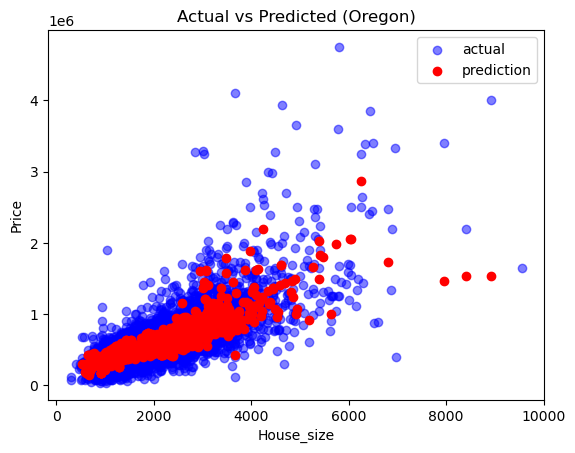

In [46]:
plt.scatter(X_oreg_plot,true_data['actual'],color='blue', label='actual',alpha= .5)
plt.scatter(X_test_plot,predictions_data['predicted'],color = 'red',marker = 'o',label='prediction')
plt.legend()
plt.xlabel('House_size')
plt.ylabel('Price')
plt.title('Actual vs Predicted (Oregon)')

### Now to do another regression with only the important features

In [35]:
X = encoded_df[['bed','bath','house_size','state_California','state_Arizona','state_Massachusetts',
               'state_District of Columbia','state_Oregon','state_Florida']]
y = encoded_df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [36]:
predictions = rf_model.predict(X_test)

In [37]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))

Mean Absolute Error (MAE): 191779.04218233135
Mean Squared Error (MSE): 117616174558.47075
R-squared (R²): 0.43765272120860743
Accuracy: 78.82 %.
Mean Absolute Percentage Error (MAPE): 2118.16


### Out of curiousity to see what the regression would look like if I dropped the most important states

In [38]:
X = encoded_df.drop(columns=['price','state_California','state_Arizona','state_Massachusetts',
               'state_District of Columbia','state_Oregon','state_Florida'])
y = encoded_df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [39]:
predictions = rf_model.predict(X_test)

In [40]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))  

Mean Absolute Error (MAE): 198845.80908433718
Mean Squared Error (MSE): 129419345099.51279
R-squared (R²): 0.3812193194270692
Accuracy: 81.34 %.
Mean Absolute Percentage Error (MAPE): 1865.76
